In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np
import numpy.polynomial.polynomial as P
import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
fs = 15
lw = 3
thr = 100

y = np.array([40.5,172.,223.5])
anchors = np.array([0.52268214, 0.92105655, 0.98927759])

ssrange = [100,150,200,250,300]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]
Sxyz = Sx + Sy + Sz

fs = 15

## Load scans

'2014SBa_R5_T49'

In [22]:
dst = '../hpcc/clean/'

walnut_batch = sorted(glob.glob('../raw/*/'))
bidx = 1
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))

widx = -2
print(walnut_files[widx])

foo = (os.path.splitext(os.path.split(walnut_files[widx])[1])[0]).split('_')
bname, lname = os.path.split(walnut_files[widx])
lname = os.path.splitext(lname)[0]
bname = bname.split('/')[-1]
#lname = foo[-1]
#bname = '_'.join(foo[:-1])
wdst = dst + bname + '/'
wdstn = wdst + 'normalization/'

if not os.path.isdir(wdstn):
    os.makedirs(wdstn)
    
print(wdst, bname, '_', lname, '.tif', sep='')

../raw/2014SBa_R5_T49/008.tif
../hpcc/clean/2014SBa_R5_T49/2014SBa_R5_T49_008.tif


In [18]:
img = tf.imread(walnut_files[widx])//256
img = img.astype(np.uint8)
fname = bname + '_' + lname
print(fname)
coeffile = wdstn + 'normalization_coefficients' + lname + '.csv'

if os.path.isfile(coeffile):
    npz = P.Polynomial(np.loadtxt(coeffile))
else:
    hist0,bins = np.histogram(img, bins=2**(img.dtype.itemsize*8),range=(0,2**(img.dtype.itemsize*8)))
    fhist = ndimage.median_filter(hist0, size=5, mode='constant', cval=0)
    cumul = np.cumsum(fhist)

2014SBa_R5_T49_008


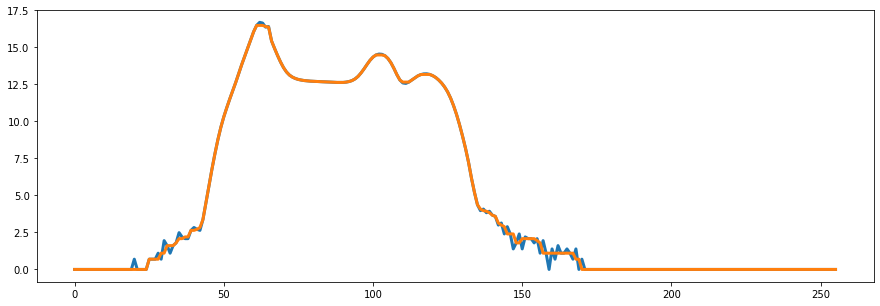

In [19]:
if not os.path.isfile(coeffile):
    lw=3
    fig = plt.figure(figsize=(15,5))
    plt.plot(np.log(hist0 +1), lw=lw);
    plt.plot(np.log(fhist+1), lw=lw);

In [20]:
if not os.path.isfile(coeffile):

    tot = cumul[-1]
    x = np.zeros(len(anchors))
    for i,a in enumerate(anchors):
        for j,s in enumerate(cumul):
            if s>a*tot:
                print('[ {} , {:03d} ]:\t {} > {:.3f}*{}\t = {:.0f}'.format(i,j,s,a,tot,a*tot))
                #print('[',i,',',j,']: ',s,'>',a,'*',tot,'=',a*tot)
                break
        if j > 0:
            x[i] = j-1+(a*tot-cumul[j-1])/(cumul[j]-cumul[j-1])
        else:
            x[i] = 0
    print('\n',x)

    npz = P.Polynomial.fit(x,y,1)
    print(npz.convert().coef)

[ 0 , 064 ]:	 78250920 > 0.523*135888457	 = 71026470
[ 1 , 105 ]:	 126621687 > 0.921*135888457	 = 125160953
[ 2 , 121 ]:	 134617300 > 0.989*135888457	 = 134431405

 [ 63.45652481 104.05000598 120.56378606]
[-163.00630411    3.21108722]


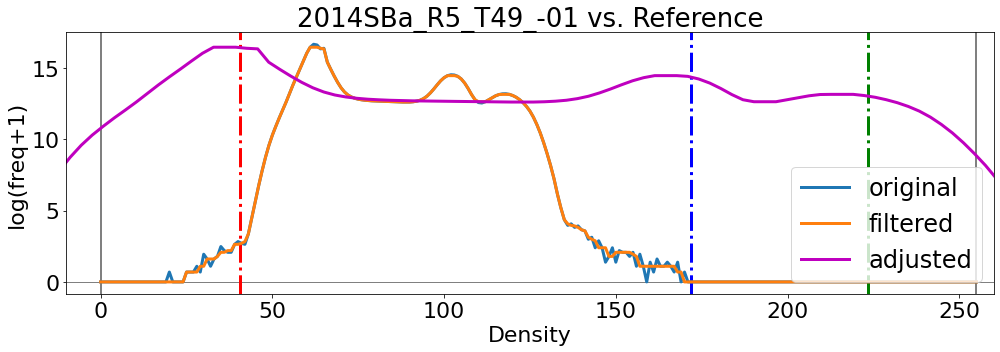

In [23]:
if not os.path.isfile(coeffile):

    fig, ax = plt.subplots(figsize=(14,5))
    lw = 3

    ax.axhline(0, c='gray', lw=1)
    ax.axvline(y[0], ls='-.', lw=lw, c='r')
    ax.axvline(y[1], ls='-.', lw=lw, c='b')
    ax.axvline(y[2], ls='-.', lw=lw, c='g')
    ax.axvline(0, c='gray', lw=2)
    ax.axvline(255, c='gray', lw=2)

    ax.plot(bins[:-1], np.log(hist0+1), lw=lw, label = 'original')
    ax.plot(bins[:-1], np.log(fhist+1), lw=lw, label = 'filtered')
    ax.plot(npz(bins[:-1]), np.log(fhist+1), lw=lw, label = 'adjusted', c='m')

    ax.set_xlabel("Density", fontsize=22)
    ax.set_ylabel("log(freq+1)", fontsize=22)
    ax.set_title(bname + '_{:03d} vs. Reference'.format(widx+1), fontsize=26)
    ax.tick_params(labelsize=22)
    ax.legend(fontsize=24)
    plt.tight_layout()

    ax.set_xlim(-10,260);

    filename = wdstn + fname + '_histogram'
    plt.savefig(filename + '.pdf', dpi=200, bbox_inches='tight', pil_kwargs={'optimize':True}, facecolor='white')

In [24]:
aimg = img.copy()
aimg = wnut.normalize_density(aimg, npz)

struc = ndimage.generate_binary_structure(img.ndim, 2)
cimg = aimg.copy()
cimg[cimg < thr] = 0
oimg = wnut.fill_component(cimg)
oimg = wnut.get_largest_element(oimg)

struc = ndimage.generate_binary_structure(img.ndim, 1)

eimg = ndimage.binary_erosion(oimg, struc, 3, border_value=1)
eimg = ndimage.binary_dilation(eimg, struc, 3, border_value=0)

cimg = (eimg > 0)*aimg


Closed X
Closed Y
Closed Z
41 components	 1 preserved
[52127566       65       34       26       23       22       20       13
       13       13        7        7        7        7        6        6
        6        5        5        5]


../hpcc/clean/2014SBa_R5_T49/normalization/air_removal_2014SBa_R5_T49_008.jpg


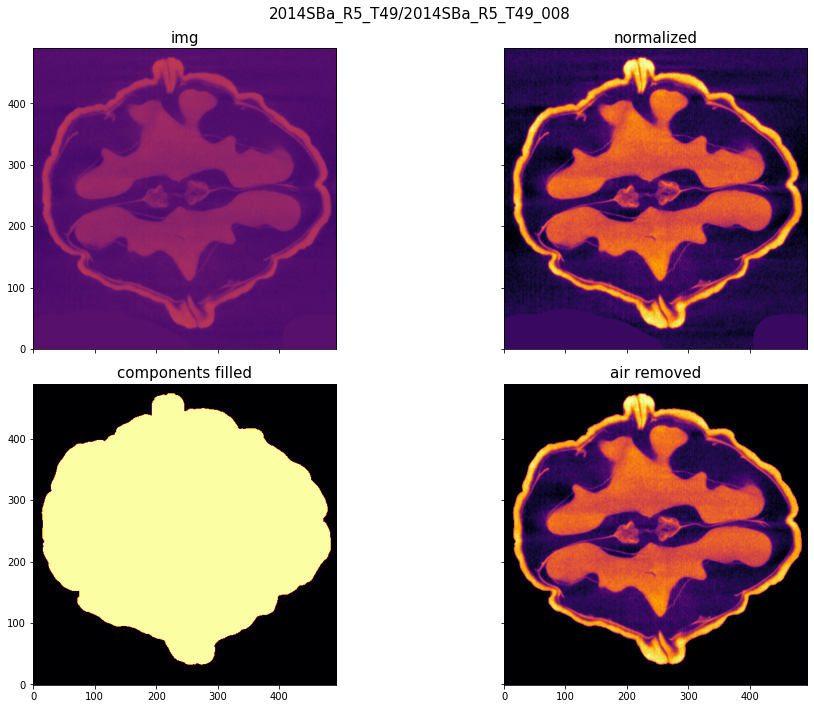

In [27]:
k = 250
ss = np.s_[k,:, :]

fig, ax = plt.subplots(2,2,figsize=(15,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('img', fontsize=fs)
i = 1
ax[i].imshow(aimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('normalized', fontsize=fs)
i = 2
ax[i].imshow(oimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
ax[i].set_title('components filled', fontsize=fs)
i = 3
ax[i].imshow(cimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('air removed', fontsize=fs)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()
filename = wdst + 'normalization/air_removal_' + fname + '.jpg'
print(filename)
#plt.savefig(filename, dpi=100, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})

In [29]:
walnut, cero = wnut.clean_zeroes(cimg)
np.savetxt(wdstn + 'clean_zeroes' + lname + '.csv', cero, fmt='%d', delimiter = ',')

bwalnut = walnut.copy()
bwalnut[bwalnut > 0] = 1

fwalnut = walnut.copy()
fwalnut[fwalnut > 0] = 1
fwalnut = ndimage.binary_fill_holes(fwalnut)

diff = fwalnut - bwalnut

walnut[diff > 0] = 1

dist1 = ndimage.distance_transform_cdt(walnut, metric='taxicab')
mask1 = (walnut > 130) | (dist1 > 15)
mask1 = ndimage.binary_dilation(mask1, struc, 7, border_value=0)
mask1 = ndimage.binary_fill_holes(mask1)
mask1 = ndimage.binary_erosion(mask1, struc, 7, border_value=1)
clean = mask1*walnut

13 % reduction from input


In [39]:
dist2 = ndimage.distance_transform_cdt(clean, metric='taxicab')

mask2 = (clean > 120) | (dist2 > 14)
mask2 = ndimage.binary_dilation(mask2, struc, 5, border_value=0)
mask2 = ndimage.binary_fill_holes(mask2)
mask2 = ndimage.binary_erosion(mask2, struc, 5, border_value=1)
clean2 = mask2*clean

print(np.sum(clean > 0))
print(np.sum(clean2 > 0))
print('----')
print(np.sum(clean > 0) - np.sum(clean2 > 0))

43027955
42496129
----
531826


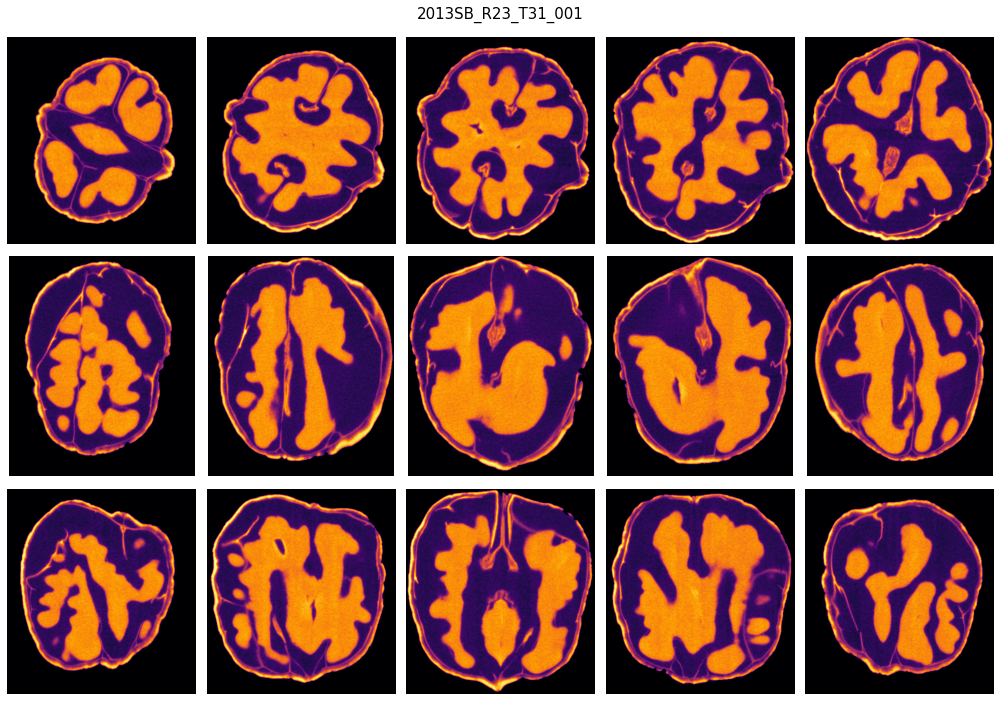

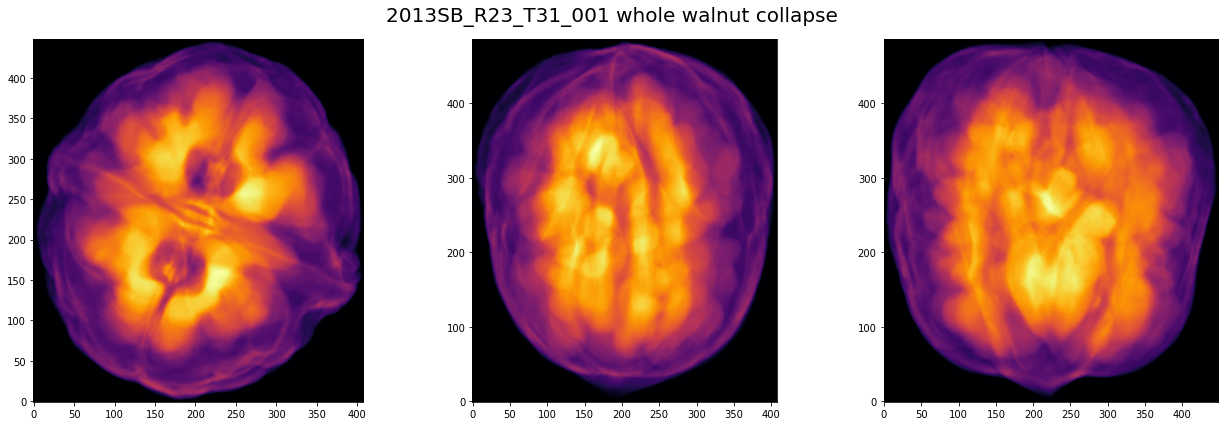

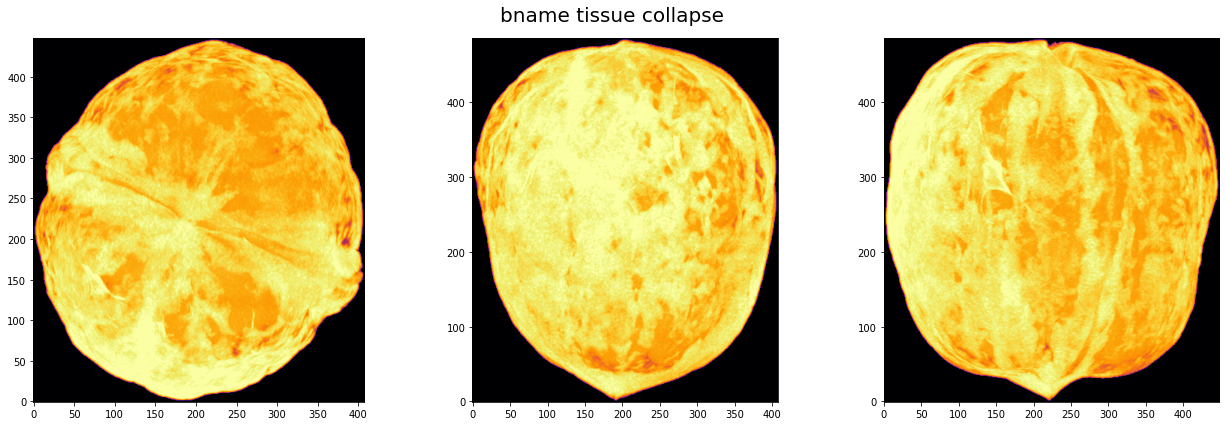

In [45]:
fig, ax = plt.subplots(3,5,figsize=(14,10), sharex=False, sharey=False)
for i in range(3):
    for j in range(len(ssrange)):
        ss = Sxyz[5*i + j]
        ax[i,j].imshow(clean[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
        ax[i,j].axis('off')
fig.suptitle(fname, fontsize=fs, color='black');
fig.tight_layout()

filename = wdstn + fname + '_slices.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
#plt.close()

snaps = wnut.collapse_dimensions(clean)
wnut.plot_collapse_dimensions(snaps, fname, 'whole walnut', dst=wdst)
snaps = wnut.collapse_dimensions_max(clean)
wnut.plot_collapse_dimensions(snaps)

In [46]:
filename = wdst + fname + '.tif'
print(filename)
tf.imwrite(filename, clean, photometric='minisblack', compress=3)

../hpcc/clean/2013SB_R23_T31/2013SB_R23_T31_001.tif
